# Анализ пользовательского поведения в мобильном приложении

## Описание проекта

   В данном проекте были изучены принципы событийной аналитики. Построена воронка продаж, исследован путь пользователей до покупки. Проанализирован результаты A/B-теста введения новых шрифтов. Были сравнены 2 контрольные группы между
собой, убедились в правильном разделении трафика, а затем сравнены с тестовой группой. Выявлено, что новый шрифт значительно не повлияет на поведение пользователей.
    
## Описание данных

Каждая запись в логе — это действие пользователя, или событие. 
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Цель: 

- Изучить воронку продаж.  
- Исследовать результаты A/A/B-эксперимента и выяснить, какой шрифт лучше.
- Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

### Задачи:

1. Загрузить данные из файла `/datasets/logs_exp.csv`. Выполнить предобработку данных.
2. Добавьте столбец даты и времени, а также отдельный столбец дат;
3. Изучить и проверить данные:
    - Сколько всего событий в логе?
    - Сколько всего пользователей в логе?
    - Сколько в среднем событий приходится на пользователя?
    - Данными за какой период я располагаю? Найти максимальную и минимальную дату. Изучить, как меняется количество данных: построить столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что имеются одинаково полные данные за весь период? Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени я располагаю на самом деле?
    - Много ли событий и пользователей потеряли, отбросив старые данные?
    - Проверить, что есть пользователи из всех трёх экспериментальных групп.
4. Изучить воронку событий:
    - Посмотреть, какие события есть в логах, как часто они встречаются. Отсортировать события по частоте.
    - Посчитать, сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть бы раз совершали событие.
    - Предположить, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?
    - По воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).
    - На каком шаге теряется больше всего пользователей?
    - Какая доля пользователей доходит от первого события до оплаты?
5. Изучить результаты эксперимента:
    - Сколько пользователей в каждой экспериментальной группе?
    - Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверить, находят ли статистические критерии разницу между выборками 246 и 247.
    - Выбрать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой из контрольных групп. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Проделать то же самое для всех других событий.
    - Аналогично поступить с группой с изменённым шрифтом. Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой.
    - Посчитать, сколько проверок статистических гипотез сделано.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats as st
import math as mth

#### 1. Загрузим данные из файла `/datasets/logs_exp.csv`. Выполним предобработку данных.

In [2]:
try:
    logs_exp = pd.read_csv('logs_exp.csv', sep='\t')
except:
    logs_exp = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
logs_exp.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
logs_exp = logs_exp.rename(
    columns={
        'EventName': 'event_name',
        'DeviceIDHash': 'user_id',
        'EventTimestamp': 'timestamp',
        'ExpId': 'group'
    }
)

In [6]:
logs_exp.isna().sum()

event_name    0
user_id       0
timestamp     0
group         0
dtype: int64

In [7]:
logs_exp.duplicated().sum()

413

In [8]:
logs_exp = logs_exp.drop_duplicates()
logs_exp

,event_name,user_id,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [9]:
logs_exp['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [10]:
logs_exp['group'].unique()

array([246, 248, 247], dtype=int64)

In [11]:
logs_exp['user_id'].unique()

array([4575588528974610257, 7416695313311560658, 3518123091307005509, ...,
       6660805781687343085, 7823752606740475984, 3454683894921357834],
      dtype=int64)

Пропусков в данных нет, дубликаты удалены. 

#### 2. Добавим столбец даты и времени, а также отдельный столбец дат:

In [12]:
logs_exp['datetime'] = pd.to_datetime(logs_exp['timestamp'], unit='s')

In [13]:
logs_exp['date'] = pd.to_datetime(logs_exp['datetime']).dt.date

In [14]:
logs_exp.head()
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   timestamp   243713 non-null  int64         
 3   group       243713 non-null  int64         
 4   datetime    243713 non-null  datetime64[ns]
 5   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


#### Вывод:
Загрузили файл и проверили данные на пропуски и дубликаты. Пропусков небыло обнаружино, а дубликаты удилены. Переименовала столбцы для лучшего понимания и удобства. Столбец с датой и временем перевела к типу datetime, а также добавила отдельный столбец с датой события. Теперь данные готовы к дальнейшему изучению.

#### 3. Изучим и проверим данные

***Выясним сколько всего событий в логе:***

In [15]:
events = logs_exp['event_name'].count()
events

243713

In [16]:
logs_exp['event_name'].nunique()

5

Итак всего у нас 244126 событий и 5 уникальные.

***Всего пользователей в логе:***

In [17]:
users = logs_exp['user_id'].nunique()
users

7551

Всего 7551 уникальных пользователей

***Подсчитаем сколько в среднем событий приходится на пользователя***:

In [18]:
ave_events = round(events / users)
ave_events

32

Примерно 32 события приходится на одного пользователя.

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

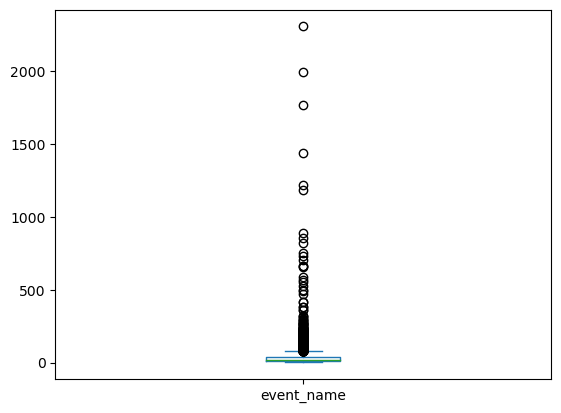

In [19]:
logs_exp.groupby('user_id')['event_name'].count().plot.box()
logs_exp.groupby('user_id')['event_name'].count().describe()

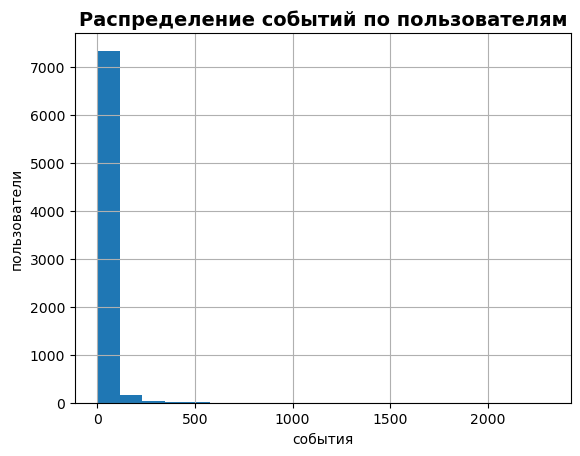

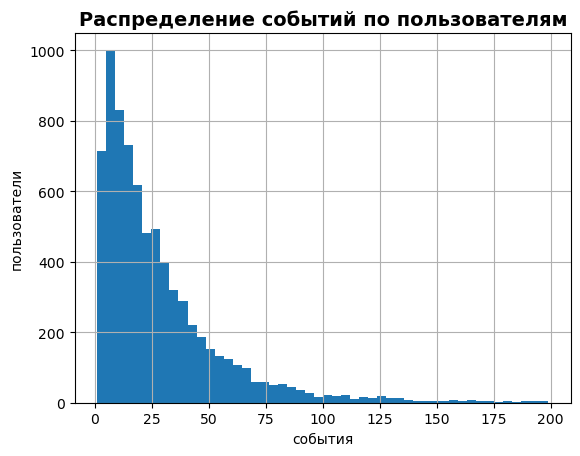

In [20]:
logs_agg = logs_exp.pivot_table(index='user_id', values='event_name', aggfunc='count')
logs_agg.sort_values(by='event_name', ascending=False).hist(bins=20)
plt.title('Распределение событий по пользователям', fontsize=14, fontweight="bold")
plt.xlabel('события')
plt.ylabel('пользователи')
plt.show()
logs_agg.query('event_name < 200').hist(bins=50)
plt.title('Распределение событий по пользователям', fontsize=14, fontweight="bold")
plt.xlabel('события')
plt.ylabel('пользователи')
plt.show()

В данных есть выбросы и судя по всему среднее значение не отображает действительность. Если воспользоваться медианным значением, то на пользователя приходится 20 событий, что на 12 меньше среднего. Минимально на пользователя одно событие, а  максимальное 2307 событий. 
Очевидно, что эти данные представляют собой сильно смещенное нормальное распределение. Слева от пика есть небольшой хвост.

***Определим максимальную и минимальную дату. Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что имеются одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Данными за какой период времени располагаем на самом деле?***

In [21]:
logs_exp['datetime'].min()

Timestamp('2019-07-25 04:43:36')

In [22]:
logs_exp['datetime'].max()

Timestamp('2019-08-07 21:15:17')

In [23]:
logs_exp['datetime'].max() - logs_exp['datetime'].min()

Timedelta('13 days 16:31:41')

Самая ранняя дата события 2019-07-25 04:43:36, а самая поздняя 2019-08-07 21:15:17. Период составляет 13 дней.

In [24]:
datesGroups = logs_exp.groupby('date').agg({'group': 'first', 'event_name': 'count'})
datesGroups.columns = ['group', 'events']
datesGroups

,group,events
date,,
2019-07-25,246,9
2019-07-26,246,31
2019-07-27,246,55
2019-07-28,246,105
2019-07-29,246,184
2019-07-30,246,412
2019-07-31,247,2030
2019-08-01,246,36141
2019-08-02,248,35554


In [25]:
g246 = datesGroups[datesGroups['group']==246][['events']]
g247 = datesGroups[datesGroups['group']==247][['events']]
g248 = datesGroups[datesGroups['group']==248][['events']]
g246

,events
date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-08-01,36141
2019-08-06,35788


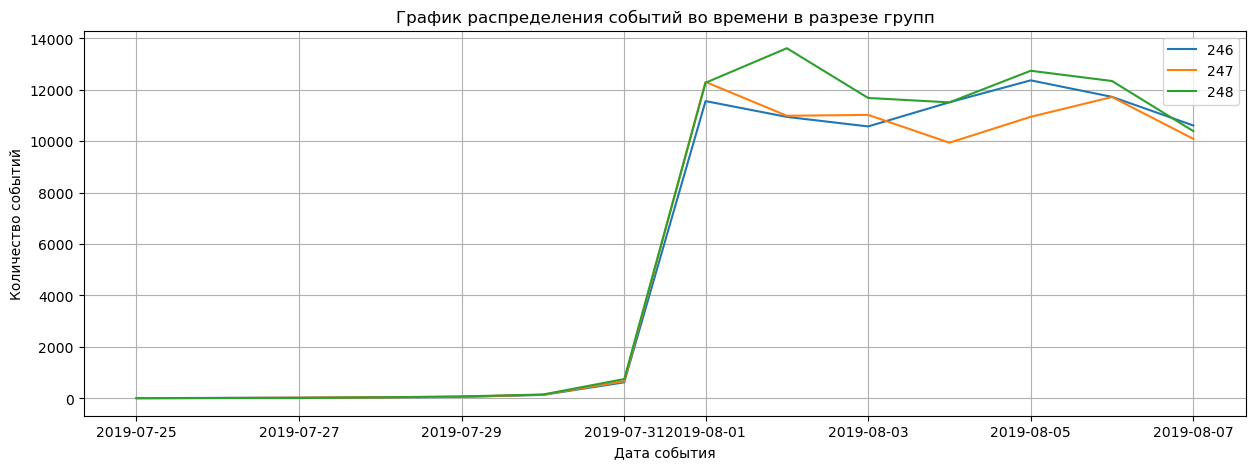

In [26]:
logs_exp.pivot_table(
    index='date',  # дата события
    columns='group',  # группа
    values='event_name',  # события
    aggfunc='count'  # количество событий
).plot(figsize=(15, 5), grid=True)

plt.title('График распределения событий во времени в разрезе групп')
plt.xlabel('Дата события')
plt.ylabel('Количество событий')
plt.legend()
plt.show()

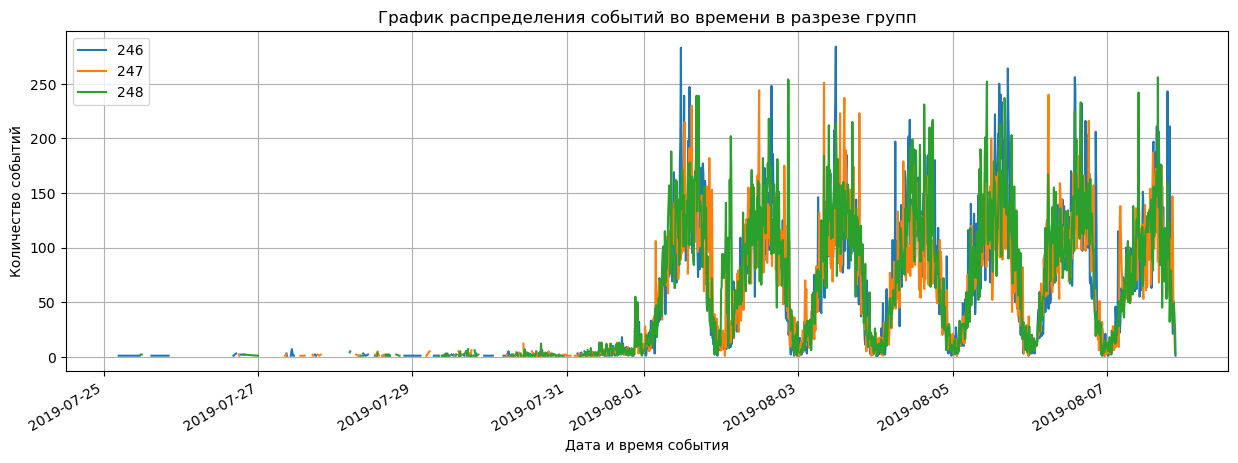

In [27]:
logs_exp['dt10m'] = logs_exp['datetime'].dt.round('10T')

logs_exp.pivot_table(
    index='dt10m',  # дата события
    columns='group',  # группа
    values='event_name',  # события
    aggfunc='count'  # количество событий
).plot(figsize=(15, 5), grid=True)
plt.title('График распределения событий во времени в разрезе групп')
plt.xlabel('Дата и время события')
plt.ylabel('Количество событий')
plt.legend()
plt.show()

Первая половина графиков находится около нуля и с 1 августа 2019 года они поднимаются выше 10000. В течение дня они скачат, наибольшее количество событий наблюдается в середине дня. За утро они растут, а вечером падают. Теперь можно с уверенностью утверждать, что данными мы располагаем за первую неделю авгута, а все остальное можно отбросить.

***Много ли событий и пользователей потеряли, отбросив старые данные?***

In [28]:
cleared_data = logs_exp[logs_exp['datetime'] > '2019-07-31 21:00:00'].reset_index(drop=True)
cleared_data

,event_name,user_id,timestamp,group,datetime,date,dt10m
0,MainScreenAppear,7701922487875823903,1564606857,247,2019-07-31 21:00:57,2019-07-31,2019-07-31 21:00:00
1,MainScreenAppear,2539077412200498909,1564606905,247,2019-07-31 21:01:45,2019-07-31,2019-07-31 21:00:00
2,OffersScreenAppear,3286987355161301427,1564606941,248,2019-07-31 21:02:21,2019-07-31,2019-07-31 21:00:00
3,OffersScreenAppear,3187166762535343300,1564606943,247,2019-07-31 21:02:23,2019-07-31,2019-07-31 21:00:00
4,MainScreenAppear,1118952406011435924,1564607005,248,2019-07-31 21:03:25,2019-07-31,2019-07-31 21:00:00
...,...,...,...,...,...,...,...
241719,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07,2019-08-07 21:10:00
241720,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07,2019-08-07 21:10:00
241721,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07,2019-08-07 21:10:00
241722,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07,2019-08-07 21:10:00


In [29]:
#cleared_user = logs_exp['user_id'].nunique()
print('Потеря cоставила: ', logs_exp['user_id'].nunique() - cleared_data['user_id'].nunique(), 'пользователей.')
print(
    'Доля потери пользователей составляет:',
      round(
          (logs_exp['user_id'].nunique() - cleared_data['user_id'].nunique())/logs_exp['user_id'].nunique()*100,
          2),
      '%'
     )

Потеря cоставила:  13 пользователей.
Доля потери пользователей составляет: 0.17 %


In [30]:
print()
print('Потеря составила', logs_exp['event_name'].count() - cleared_data['event_name'].count(), 'событий.')
print('Доля потери событий составляет:', round((logs_exp['event_name'].count() - cleared_data['event_name'].count())/logs_exp['event_name'].count()*100, 2), '%')


Потеря составила 1989 событий.
Доля потери событий составляет: 0.82 %


После того как мы отбросили старые данные потеря пользователей составила 0,17%, а событий 0,82%. Это вполне допустимые значения, так как данных получилось отбросить меньше 1%.

***Проверим, что есть пользователи из всех трёх экспериментальных групп.***

In [31]:
cleared_data.groupby('group')['user_id'].nunique()

group
246    2484
247    2517
248    2537
Name: user_id, dtype: int64

Количество уникальных пользователей распределяется по группам примерно одинаково.

#### Вывод:
Всего в логе 243713 событий из них 5 уникальных. Количество ползователей - 7551. В среднем на одного пользователя приходится 32 события, но так как в данных имеются выбрасы возьмем медианное значени которое равно 20 событиям на пользователя. Мы расплагаем данными за 13 дней, но из них собылия захватывают лишь 7. Остальное пришлось удалить. В результате мы потеряли данные по 13 пользователям и 1989 событиям. Эти потери не превылисли 1%.

#### 4. Изучим воронку событий:

***Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.***

In [32]:
cleared_data['event_name'].unique()

array(['MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful', 'CartScreenAppear', 'Tutorial'],
      dtype=object)

In [33]:
cleared_data['event_name'].value_counts()

MainScreenAppear           117889
OffersScreenAppear          46531
CartScreenAppear            42343
PaymentScreenSuccessful     33951
Tutorial                     1010
Name: event_name, dtype: int64

Всего пять уникальных событий, самое часто встречающееся событие это "MainScreenAppear" их 117992, а самые редкие это "Tutorial" их 1044.

***Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.***

In [34]:
cleared_data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

event_name
MainScreenAppear           7423
OffersScreenAppear         4597
CartScreenAppear           3736
PaymentScreenSuccessful    3540
Tutorial                    843
Name: user_id, dtype: int64

In [35]:
user_data = cleared_data.groupby('event_name').agg({'event_name': 'count', 'user_id': 'nunique'})
user_data.columns = ['event_count', 'user_count']
user_data['users_share'] = (user_data['user_count']/cleared_data['user_id'].nunique()*100).round(2)
user_data = user_data.sort_values(by='users_share', ascending=False)
user_data

,event_count,user_count,users_share
event_name,,,
MainScreenAppear,117889,7423,98.47
OffersScreenAppear,46531,4597,60.98
CartScreenAppear,42343,3736,49.56
PaymentScreenSuccessful,33951,3540,46.96
Tutorial,1010,843,11.18


#### Вывод:
Получили варонку событий. Самым популярным событием является MainScreenAppear (Появление главного экрана). Доля пользователей этого события составляет 98.47%. Не все пользователи совершили это событие, возможно это связанно с тем, что некоторые пользователи прошли по ссылке с рекламой определенного продукта минуя главный экран. Самым не популярным является Tutorial (Руководство) - 11.18% пользователей.  

***Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?***

В переводе на русский язык события такие:
- MainScreenAppear - Появление главного экрана;
- OffersScreenAppear - Появляется экран предложений;
- CartScreenAppear - Появление экрана корзины;
- PaymentScreenSuccessful - Экран оплаты прошел успешно;
- Tutorial - Руководство.

Можно предположить, что события шли по такой цепочке: MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful → Tutorial. То есть сначала пользователь открыл гланый экран с набором предложений, затем кликом перешел в нужное предложение. После того как выбран нужный товар и добавлен в корзину, ползователь переходит в корзину и открывается экран корзины где оформляется заказ. После оформления заказа открывается экран на котором видна информация о результате оплаты. Завершает цепочку руководство по получению оплаченного товара. Возможно последнее событие может быть инструкцией по оформлению заказа или использованию приложения. В зависимости от назначения это событие можно поставить как в конц, так и в начало цепочки. Отвечая на вопрос "Все ли они выстраиваются в последовательную цепочку?" стоит выделить как раз событие "Tutorial", которе можно изключить из этой цепочки.

***По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитать отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.***

In [36]:
user_data['conversion'] = round(user_data['user_count'] / user_data['user_count'].shift(periods=1, fill_value=7423), 2)*100
user_data

,event_count,user_count,users_share,conversion
event_name,,,,
MainScreenAppear,117889,7423,98.47,100.0
OffersScreenAppear,46531,4597,60.98,62.0
CartScreenAppear,42343,3736,49.56,81.0
PaymentScreenSuccessful,33951,3540,46.96,95.0
Tutorial,1010,843,11.18,24.0


***На каком шаге теряется больше всего пользователей?***

Значительная потеря пользователей происходит на втором шаге, когда происходит переход с обшего экрана на экран с предложением. 

***Какая доля пользователей доходит от первого события до оплаты?***

In [37]:
round(user_data['user_count'][3]/user_data['user_count'][0], 2)*100

48.0

#### Вывод:
Установили последовательность событий и построили воронку. Всего 62% пользователей перешли с главного экрана на экран предложений. Далее потери не такие значительные. На экран корзины преходит 81%, с корзины на экран оплаты 95%. По итогу 48% пользователей доходит от первого события до оплаты и это хороший показатель. Событие Tutorial решили не включать в воронку, так как оно выбивается из последовательной цепочки.

#### 5. Изучим результаты эксперимента:

***Сколько пользователей в каждой экспериментальной группе?***

In [38]:
group = cleared_data['group'].unique()
for i in group:
    print("В группе", i,"-", cleared_data[cleared_data['group'] == i]['user_id'].nunique(), "пользователей.")

В группе 247 - 2517 пользователей.
В группе 248 - 2537 пользователей.
В группе 246 - 2484 пользователей.


In [39]:
gr_246 = cleared_data[cleared_data['group']==246]['user_id'].unique()
gr_247 = cleared_data[cleared_data['group']==247].query('user_id in @gr_246')['user_id']
gr_247 = gr_247.unique()
print('id пользователей из группы 247 попавшие в группу 246:', gr_247)
gr_248 = cleared_data[cleared_data['group']==248].query('user_id in @gr_246')['user_id']
print('id пользователей из группы 248 попавшие в группу 246:', gr_248)
print()

id пользователей из группы 247 попавшие в группу 246: []
id пользователей из группы 248 попавшие в группу 246: Series([], Name: user_id, dtype: int64)



***Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.***

***Выбрем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Выполним то же самое для всех других событий.***

Критерии успешного A/A-теста:

    - Количество пользователей в различных группах различается не более, чем на 1%;

    - Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;

    - Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;

    - Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

#### Вывод:
В данном проекте можем учитывать не все критерии. Проверим корректость выбора групп по **первому** критерию:

In [40]:
user_group = cleared_data.groupby('group')['user_id'].nunique()
print("Количество пользователей в группах 246 и 247 различается на ", round((user_group[247] - user_group[246])/user_group[247]*100), "%")

Количество пользователей в группах 246 и 247 различается на  1 %


По **второму** критерию в рамких этого проекта проверить не сможем. По **последнему** критерю мы убедились, что пользователей попавших в обе группы одновременно нет. Остался пункт **"Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости"** который мы проверим далее.

In [41]:
user_group = cleared_data.groupby('group')['user_id'].nunique()
user_group

group
246    2484
247    2517
248    2537
Name: user_id, dtype: int64

In [42]:
tab_group = cleared_data[cleared_data['event_name'] != 'Tutorial'].pivot_table(index='group', columns = 'event_name', values='user_id',aggfunc='nunique')
tab_group = tab_group.merge(user_group, left_on=['group'], right_on=['group']).rename(columns={'user_id': 'total'})
tab_group

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,total
group,,,,,
246,1266,2450,1542,1200,2484
247,1239,2479,1524,1158,2517
248,1231,2494,1531,1182,2537


In [43]:
def stst_test(successes, trials, alpha):
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 


    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [44]:
CartScreenAppear = ([tab_group['CartScreenAppear'][246], tab_group['CartScreenAppear'][247]])
MainScreenAppear = ([tab_group['MainScreenAppear'][246], tab_group['MainScreenAppear'][247]])
OffersScreenAppear = ([tab_group['OffersScreenAppear'][246], tab_group['OffersScreenAppear'][247]])
PaymentScreenSuccessful = ([tab_group['PaymentScreenSuccessful'][246], tab_group['PaymentScreenSuccessful'][247]])
total = ([tab_group['total'][246], tab_group['total'][247]])

- Нулевая гипотеза: между долями двух выборок нет значимой разницы.
- Альтернативня гипотеза: доли двух выборок различаются.

Проверим на статистически значимое различие групп **А1/A2 (246/247)** по самому популярному событию:

Выберем уровень значимости **alpha=0.01**.

In [45]:
stst_test(MainScreenAppear, total, 0.01)

p-значение:  0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


А так же остальные события:

In [46]:
stst_test(CartScreenAppear, total, 0.01)

p-значение:  0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [47]:
stst_test(OffersScreenAppear, total, 0.01)

p-значение:  0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [48]:
stst_test(PaymentScreenSuccessful, total, 0.01)

p-значение:  0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


После проверки по всем критерям, можно считать, что разбивка на группы бала прведена корректно. Статистически значимых различий не выявлено. Теперь можно проводить А/В тест.

Самым популярным событием является "MainScreenAppear"(Появление главного экрана) доля пользователей его составляет 98,47%.

In [49]:
# число пользователей, совершивших это событие в каждой из контрольных групп:
user_MSA = cleared_data[cleared_data['event_name']=='MainScreenAppear'].groupby('group')['user_id'].nunique()
user_MSA

group
246    2450
247    2479
248    2494
Name: user_id, dtype: int64

In [50]:
# доля пользователей, совершивших это событие:
conv_MSA = round(tab_group['MainScreenAppear'] / tab_group['total'] * 100, 1)
conv_MSA

group
246    98.6
247    98.5
248    98.3
dtype: float64

***Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.***

In [51]:
CartScreenAppear = ([tab_group['CartScreenAppear'][246], tab_group['CartScreenAppear'][248]])
MainScreenAppear = ([tab_group['MainScreenAppear'][246], tab_group['MainScreenAppear'][248]])
OffersScreenAppear = ([tab_group['OffersScreenAppear'][246], tab_group['OffersScreenAppear'][248]])
PaymentScreenSuccessful = ([tab_group['PaymentScreenSuccessful'][246], tab_group['PaymentScreenSuccessful'][248]])
total = ([tab_group['total'][246], tab_group['total'][248]])

Проверим на статистически значимое различие групп **А1/В (246/248)**:

Выберем уровень значимости **alpha=0.05**.

In [52]:
stst_test(MainScreenAppear, total, 0.05)

p-значение:  0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [53]:
stst_test(CartScreenAppear, total, 0.05)

p-значение:  0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [54]:
stst_test(OffersScreenAppear, total, 0.05)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [55]:
stst_test(PaymentScreenSuccessful, total, 0.05)

p-значение:  0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Теперь проверим различие групп **А2/В (247/248)**:

In [56]:
CartScreenAppear = ([tab_group['CartScreenAppear'][247], tab_group['CartScreenAppear'][248]])
MainScreenAppear = ([tab_group['MainScreenAppear'][247], tab_group['MainScreenAppear'][248]])
OffersScreenAppear = ([tab_group['OffersScreenAppear'][247], tab_group['OffersScreenAppear'][248]])
PaymentScreenSuccessful = ([tab_group['PaymentScreenSuccessful'][247], tab_group['PaymentScreenSuccessful'][248]])
total = ([tab_group['total'][247], tab_group['total'][248]])

In [57]:
stst_test(MainScreenAppear, total, 0.05)

p-значение:  0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [58]:
stst_test(CartScreenAppear, total, 0.05)

p-значение:  0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [59]:
stst_test(OffersScreenAppear, total, 0.05)

p-значение:  0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [60]:
stst_test(PaymentScreenSuccessful, total, 0.05)

p-значение:  0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Объеденим контрольные группы 246 и 247 в одну:

In [61]:
tab_group.loc['246/7'] = [2505, 4929, 3066, 2358, 5001]
tab_group

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,total
group,,,,,
246,1266,2450,1542,1200,2484
247,1239,2479,1524,1158,2517
248,1231,2494,1531,1182,2537
246/7,2505,4929,3066,2358,5001


In [62]:
CartScreenAppear = ([tab_group['CartScreenAppear']['246/7'], tab_group['CartScreenAppear'][248]])
MainScreenAppear = ([tab_group['MainScreenAppear']['246/7'], tab_group['MainScreenAppear'][248]])
OffersScreenAppear = ([tab_group['OffersScreenAppear']['246/7'], tab_group['OffersScreenAppear'][248]])
PaymentScreenSuccessful = ([tab_group['PaymentScreenSuccessful']['246/7'], tab_group['PaymentScreenSuccessful'][248]])
total = ([tab_group['total']['246/7'], tab_group['total'][248]])
CartScreenAppear

[2505, 1231]

Проверим различие групп **А3/В** (246/7 и 248):

In [63]:
stst_test(MainScreenAppear, total, 0.05)

p-значение:  0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [64]:
stst_test(CartScreenAppear, total, 0.05)

p-значение:  0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [65]:
stst_test(OffersScreenAppear, total, 0.05)

p-значение:  0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [66]:
stst_test(PaymentScreenSuccessful, total, 0.05)

p-значение:  0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По итогам теста статистически значимых различий между группами А1/В и группами А2/В нет. А так же между объединенной группой А3 и В статистически значимых различий по всем событиям нет.

***Посчитаем, сколько проверок статистических гипотез сделано.***

В результате проверки было проведено четыре А/А теста и двенадцать А/В тестов.

В А/В тесте я спользовала уровень значимости alpha=0.05. Проверим вероятность ошибки по формуле $1-(1-a)^n$: 1 - (1 - 0,05)^16 = 0,56. Полученная вероятность выше уровня значимости, значит необходимо его скорректировать.
Воспользуемся методом Бонферрони:  bonferroni_alpha = alpha / 16, выходит уроветь значимости теперь 0.003, что еще мньше. Во всех экспериментах p_value превышало alpha, а это значит, что не имеет смысла проводить все тесты вновь с скорректированным уровнем значимости. В любом случае теперь мы снизили вероятность ошибки и результатам можно больше доверять.  

### 6. Вывод:

Я располагала данными о пользователях (их уникальный номер) которые совершали определенные события при использовании приложения, такие как:
 - Появление главного экрана;
 - Появляется экран предложений;
 - Появление экрана корзины;
 - Экран оплаты прошел успешно;
 - Руководство.
 
Так же период использования приложения двумя контрольными группами, которые использовали приложение со старым шрифтом и одной экспериментальной группой с новым. Самым полупьяным событием было "Появление главного экрана". Чтобы дать ответ повлияет ли изменение шрифта на использование данного приложения,  я провела несколько тестов на проверку гипотез о равенстве долей по всем событиям кроме "Руководство". Так как данное событие не участвует в воронке. Во всех событиях тесты показали одинаковый результат.
В итоге можно заключить, что на пользователей никак не повлияло изменение шрифта приложения. Но стоит заметить, что данные пришлось урезать,  и мы располагали лишь одной неделею.  Было бы лучше провести это исследование,  располагая большим периодом, хотя бы двумя неделями.